# Proj03_SVM_WineFraud

Credits:

- [2021 Python for Machine Learning & Data Science Masterclass by Jose Portilla Udemy](https://www.udemy.com/course/python-for-machine-learning-data-science-masterclass/)

## [Fraud in Wine](https://en.wikipedia.org/wiki/Wine_fraud)

Wine fraud relates to the commercial aspects of wine. The most prevalent type of fraud is one where wines are adulterated, usually with the addition of cheaper products (e.g. juices) and sometimes with harmful chemicals and sweeteners (compensating for color or flavor).

Counterfeiting and the relabelling of inferior and cheaper wines to more expensive brands is another common type of wine fraud.

<img src="images/wine.jpg">

**Project Goals**

A distribution company that was recently a victim of fraud has completed an audit of various samples of wine through the use of chemical analysis on samples. The distribution company specializes in exporting extremely high quality, expensive wines, but was defrauded by a supplier who was attempting to pass off cheap, low quality wine as higher grade wine. The distribution company has hired you to attempt to create a machine learning model that can help detect low quality (a.k.a "fraud") wine samples. They want to know if it is even possible to detect such a difference.


Data Source: *P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties.
In Decision Support Systems, Elsevier, 47(4):547-553, 2009.*


*TASK: Your overall goal is to use the wine dataset shown below to develop a machine learning model that attempts to predict if a wine is "Legit" or "Fraud" based on various chemical features. Complete the tasks below to follow along with the project.*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
df = pd.read_csv('data/wine_fraud.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   object 
 12  type                  6497 non-null   object 
dtypes: float64(11), object(2)
memory usage: 660.0+ KB


## EDA

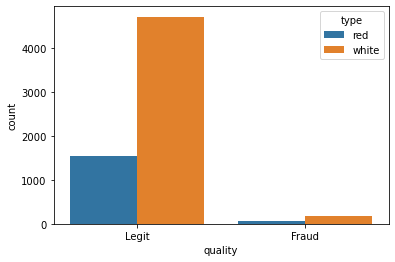

In [64]:
# How many legit whines are there?
sns.countplot(data=df,x='quality',hue='type');

- Clearly an imbalanced dataset and legit white whines are way more than legit red whines!  

In [74]:
# What % of the red and the white whines are Fraud
pct_red_fraud = 100*len(df[(df['type']=='red') & (df['quality']=='Fraud')])/len(df[df['type']=='red'])
pct_wht_fraud = 100*len(df[(df['type']=='white') & (df['quality']=='Fraud')])/len(df[df['type']=='white'])
pct_red_fraud, pct_wht_fraud

(3.9399624765478425, 3.736218864842793)

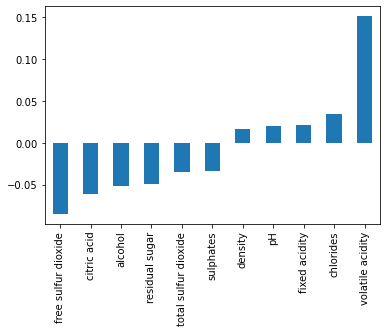

In [41]:
# Correlation between the various features and the 'quality'
# For this we need to one-hot-encode the 'quality' and 'type' cols

df['Fraud'] = df['quality'].map({'Legit':0,'Fraud':1})
df.corr()['Fraud'].sort_values()[:-1].plot(kind='bar');

## SVM

In [42]:
# Drop the 'Fraud' column
df = df.drop('Fraud',axis=1) 

In [43]:
# One-hot-encode 'type' column
df['type'] = df['type'].map({'red':0,'white':1})

In [47]:
X = df.drop('quality', axis=1)
y = df['quality']

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.1, random_state=101)

from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
scaled_X_train = scalar.fit_transform(X_train)
scaled_X_test = scalar.transform(X_test)

- We already know that the classes are unbalanced, in an attempt to help alleviate this issue, we can automatically adjust weights inversely proportional to class frequencies in the input data with a argument 'class_weight=balanced' in the SVC() call.

In [55]:
from sklearn.svm import SVC
svc = SVC(class_weight='balanced')

from sklearn.model_selection import GridSearchCV
param_grid = {'C':[0.001,0.01,0.1,0.5,1],
              'kernel':['linear','rbf','poly'],
              'gamma':['scale','auto'],
              'degree':[2,3,4]
             }
grid_model = GridSearchCV(svc,param_grid)
grid_model.fit(scaled_X_train,y_train)
print(grid_model.best_params_)
grid_pred = grid_model.predict(scaled_X_test)

{'C': 0.001, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}


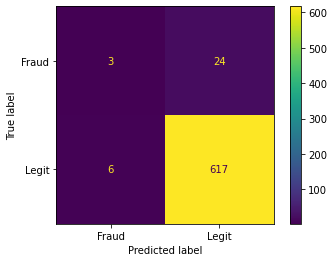

In [58]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(grid_model,scaled_X_test,y_test);

In [59]:
from sklearn.metrics import classification_report
print(classification_report(y_test,grid_pred))

              precision    recall  f1-score   support

       Fraud       0.33      0.11      0.17        27
       Legit       0.96      0.99      0.98       623

    accuracy                           0.95       650
   macro avg       0.65      0.55      0.57       650
weighted avg       0.94      0.95      0.94       650

